[Final Task] Home Credit Scorecard Model

In [ ]:
# ====================================================================================================
# TAHAP 1: SETUP & IMPORT LIBRARIES
# ====================================================================================================

import pandas as pd # Untuk mengelola data dalam bentuk DataFrame
import numpy as np # Untuk operasi numerik
import matplotlib.pyplot as plt # Untuk membuat plot statis
import seaborn as sns # Berbasis matplotlib, untuk plot yang lebih indah dan statistik
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.model_selection import train_test_split # Untuk membagi data
from sklearn.preprocessing import LabelEncoder, StandardScaler  # Untuk scaling dan encoding
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (roc_auc_score, roc_curve, accuracy_score, confusion_matrix,
                            classification_report, precision_score, recall_score, f1_score)

# Imbalanced Learning
from imblearn.over_sampling import SMOTE


In [ ]:
# ====================================================================================================
# TAHAP 2 : LOAD DATA
# ====================================================================================================

# Load main dataset
df_train = pd.read_csv('/application_train.csv')

# Muat juga deskripsi kolom, ini sangat membantu!
df_description = pd.read_csv('/HomeCredit_columns_description.csv', encoding='latin-1')
# encoding='latin-1' terkadang diperlukan jika ada karakter khusus yang membuat error saat load

In [ ]:
# ====================================================================================================
# TAHAP 3 : EKSPLORASI AWAL
# ====================================================================================================

# Memastikan kolom 'TARGET' tersedia. Berdasarkan output df_train.head() sebelumnya,
# kolom yang seharusnya menjadi 'TARGET' tampaknya diberi nama '0' (sebagai string).
# Kita akan mengganti nama kolom '0' menjadi 'TARGET'.
df_train.rename(columns={'0': 'TARGET'}, inplace=True)

#Mendapatkan Informasi Ukuran Data
num_rows, num_cols = df_train.shape

print(f"Dataset 'application_train' memiliki:")
print(f"- {num_rows} Observasi (Aplikasi Pinjaman)")
print(f"- {num_cols} Fitur (Kolom)")
print("\n")

#Mendapatkan Informasi Tipe Data
print("Informasi Tipe Data per Kolom di 'application_train':")
df_train.info()
print("\n")

#Mendapatkan Informasi Kualitas Data (Missing Values)
# Hitung jumlah missing values per kolom
missing_values_count = df_train.isnull().sum()

# Hitung persentase missing values
total_rows = len(df_train)
missing_percentage = (missing_values_count / total_rows) * 100

# Buat DataFrame untuk tampilan yang lebih rapi
missing_info = pd.DataFrame({
    'Jumlah Missing': missing_values_count,
    'Persentase Missing': missing_percentage
})

# Filter hanya kolom yang memiliki missing values dan sortir dari yang tertinggi
missing_info = missing_info[missing_info['Jumlah Missing'] > 0].sort_values(
    by='Persentase Missing', ascending=False
)

print("10 Kolom Teratas dengan Persentase Missing Values Tertinggi:")
print(missing_info.head(10)) # Menampilkan 10 kolom teratas
print("\n")

#Mendapatkan Informasi Distribusi Variabel Target (Imbalance)
target_counts = df_train['TARGET'].value_counts()
target_percentages = df_train['TARGET'].value_counts(normalize=True) * 100

print("Distribusi Variabel Target (0 = Lunas, 1 = Macet):")
print(target_counts)
print("\n")

print("Persentase Distribusi Variabel Target:")
print(target_percentages)
print("\n")

Dataset 'application_train' memiliki:
- 305588 Observasi (Aplikasi Pinjaman)
- 122 Fitur (Kolom)


Informasi Tipe Data per Kolom di 'application_train':
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305588 entries, 0 to 305587
Columns: 122 entries, 3 to 3.0.1
dtypes: float64(65), int64(41), object(16)
memory usage: 284.4+ MB


10 Kolom Teratas dengan Persentase Missing Values Tertinggi:
             Jumlah Missing  Persentase Missing
Unnamed: 76          213546           69.880362
Unnamed: 62          213546           69.880362
Unnamed: 48          213546           69.880362
Unnamed: 70          212203           69.440881
Unnamed: 84          212203           69.440881
Unnamed: 56          212203           69.440881
Unnamed: 86          209014           68.397319
Unnamed: 54          208906           68.361978
Unnamed: 82          208906           68.361978
Unnamed: 68          208906           68.361978


Distribusi Variabel Target (0 = Lunas, 1 = Macet):
TARGET
0    280903
1     

In [ ]:
# ====================================================================================================
# TAHAP 4: EKSPLORASI DATA AWAL (EDA)
# ====================================================================================================
# -------------Load dataset-------------#
from google.colab import drive
drive.mount('/content/drive') # Mount Google Drive to a standard location

# Adjust file paths to point to the correct location in your mounted Google Drive
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Final Task Home Credit/application_train.csv')
df_bureau = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Final Task Home Credit/bureau.csv')
df_bureau_balance = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Final Task Home Credit/bureau_balance.csv')

# Simpan ID asli sebelum pre-processing (penting untuk submit test data nanti)
train_id = df_train['SK_ID_CURR']

# -------------Data Merging & Agregasi-------------#
# --- 2.1 Agregasi df_bureau_balance ---
# Kita hitung status pinjaman di bureau_balance per SK_ID_BUREAU
# Contoh: Hitung persentase masing-masing status (C, X, 0, 1, 2, 3, 4, 5)
bureau_balance_agg = df_bureau_balance.groupby('SK_ID_BUREAU')['STATUS'].value_counts(normalize=True).unstack(fill_value=0)
bureau_balance_agg.columns = [f'BB_STATUS_{col}' for col in bureau_balance_agg.columns] # Ganti nama kolom

# Tambahkan jumlah observasi per SK_ID_BUREAU
bureau_balance_agg['BB_COUNT'] = df_bureau_balance.groupby('SK_ID_BUREAU').size()
bureau_balance_agg.reset_index(inplace=True)

# --- 2.2 Gabungkan hasil agregasi bureau_balance ke df_bureau ---
df_bureau = df_bureau.merge(bureau_balance_agg, on='SK_ID_BUREAU', how='left')

# --- 2.3 Agregasi df_bureau per SK_ID_CURR ---
# Ini adalah ringkasan data bureau untuk setiap pelanggan utama di application_train
# Contoh agregasi: mean, sum, max, min, std
bureau_agg_funcs = {
    'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
    'CREDIT_DAY_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum', 'var'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
    'AMT_ANNUITY': ['max', 'mean', 'sum'],
    'CNT_CREDIT_PROLONG': ['sum'],
    'SK_ID_BUREAU': ['nunique'] # Jumlah pinjaman di bureau
}
# Tambahkan juga fitur-fitur dari bureau_balance_agg yang sudah digabungkan
for col in bureau_balance_agg.columns.drop('SK_ID_BUREAU'):
    bureau_agg_funcs[col] = ['mean', 'sum', 'max']

bureau_agg = df_bureau.groupby('SK_ID_CURR').agg(bureau_agg_funcs)

# Merapikan nama kolom agregasi
bureau_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
bureau_agg.reset_index(inplace=True)

# --- 2.4 Gabungkan hasil agregasi bureau ke df_train ---
df_train = df_train.merge(bureau_agg, on='SK_ID_CURR', how='left')

print("Ukuran df_train setelah penggabungan bureau:", df_train.shape)

# -------------Penanganan Missing Values-------------#
# Dapatkan daftar kolom numerik dan kategorikal
numeric_cols = df_train.select_dtypes(include=np.number).columns.tolist()
categorical_cols = df_train.select_dtypes(include='object').columns.tolist()

# Imputasi numerik dengan median
for col in numeric_cols:
    if df_train[col].isnull().sum() > 0:
        df_train[col] = df_train[col].fillna(df_train[col].median())

# Imputasi kategorikal dengan mode
for col in categorical_cols:
    if df_train[col].isnull().sum() > 0:
        df_train[col] = df_train[col].fillna(df_train[col].mode()[0])

print("Jumlah missing values setelah imputasi:", df_train.isnull().sum().sum()) # Seharusnya 0

# Identifikasi kembali kolom kategorikal setelah imputasi (jika ada yang berubah)
categorical_cols = df_train.select_dtypes(include='object').columns.tolist()

# Terapkan One-Hot Encoding
# drop_first=True penting untuk menghindari multicollinearity, terutama untuk Logistic Regression
df_train = pd.get_dummies(df_train, columns=categorical_cols, drop_first=True)

print("Ukuran df_train setelah One-Hot Encoding:", df_train.shape)

# Contoh pembuatan fitur baru yang relevan
df_train['CREDIT_INCOME_RATIO'] = df_train['AMT_CREDIT'] / (df_train['AMT_INCOME_TOTAL'] + 1e-6) # Hindari pembagian nol
df_train['ANNUITY_INCOME_RATIO'] = df_train['AMT_ANNUITY'] / (df_train['AMT_INCOME_TOTAL'] + 1e-6)
df_train['CREDIT_ANNUITY_RATIO'] = df_train['AMT_CREDIT'] / (df_train['AMT_ANNUITY'] + 1e-6)
df_train['GOODS_PRICE_INCOME_RATIO'] = df_train['AMT_GOODS_PRICE'] / (df_train['AMT_INCOME_TOTAL'] + 1e-6)

# Konversi DAYS_BIRTH dan DAYS_EMPLOYED ke tahun
df_train['AGE_IN_YEARS'] = df_train['DAYS_BIRTH'] / -365
# Create YEARS_EMPLOYED from DAYS_EMPLOYED first
df_train['YEARS_EMPLOYED'] = df_train['DAYS_EMPLOYED'] / -365
# Tangani nilai 365243 di DAYS_EMPLOYED (seringkali berarti tidak bekerja/unknown)
# When 365243 days are divided by -365, the result is -1000 years.
# So, replacing -1000 in YEARS_EMPLOYED effectively handles the 365243 days special case.
df_train['YEARS_EMPLOYED'] = df_train['YEARS_EMPLOYED'].replace({-1000: 0})

# Bisa juga membuat fitur interaksi
df_train['AGE_EMPLOYED_INTERACTION'] = df_train['AGE_IN_YEARS'] * df_train['YEARS_EMPLOYED']

print("Ukuran df_train setelah Feature Engineering:", df_train.shape)

# Pisahkan fitur (X) dan target (y)
X = df_train.drop(['TARGET', 'SK_ID_CURR'], axis=1) # Hapus TARGET dan ID dari fitur
y = df_train['TARGET']

# Pastikan semua kolom di X adalah numerik (sisa dari encoding)
X = X.select_dtypes(include=np.number)

# Bagi data menjadi training set dan testing set
# test_size=0.2 berarti 20% data untuk testing, random_state untuk hasil yang bisa direplikasi
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # stratify penting untuk data imbalanced

print(f"Ukuran X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Ukuran X_test: {X_test.shape}, y_test: {y_test.shape}")

# Normalisasi/Standardisasi Fitur (HANYA pada fitur numerik)
scaler = StandardScaler()

# Fit scaler pada X_train SAJA, lalu transform X_train dan X_test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Kembalikan ke DataFrame agar mudah dikelola (opsional, tapi bagus untuk melihat)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Fitur sudah di-scale.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Ukuran df_train setelah penggabungan bureau: (307511, 173)
Jumlah missing values setelah imputasi: 0
Ukuran df_train setelah One-Hot Encoding: (307511, 281)
Ukuran df_train setelah Feature Engineering: (307511, 288)
Ukuran X_train: (246008, 162), y_train: (246008,)
Ukuran X_test: (61503, 162), y_test: (61503,)
Fitur sudah di-scale.


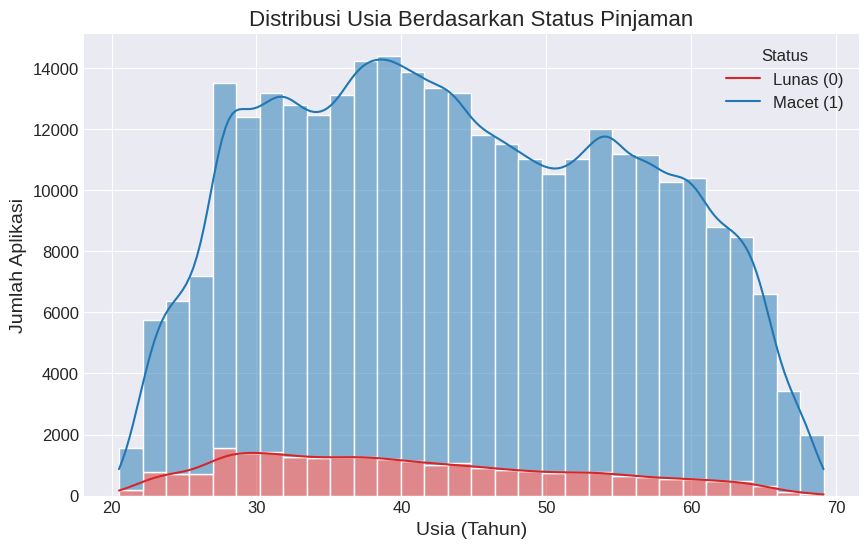

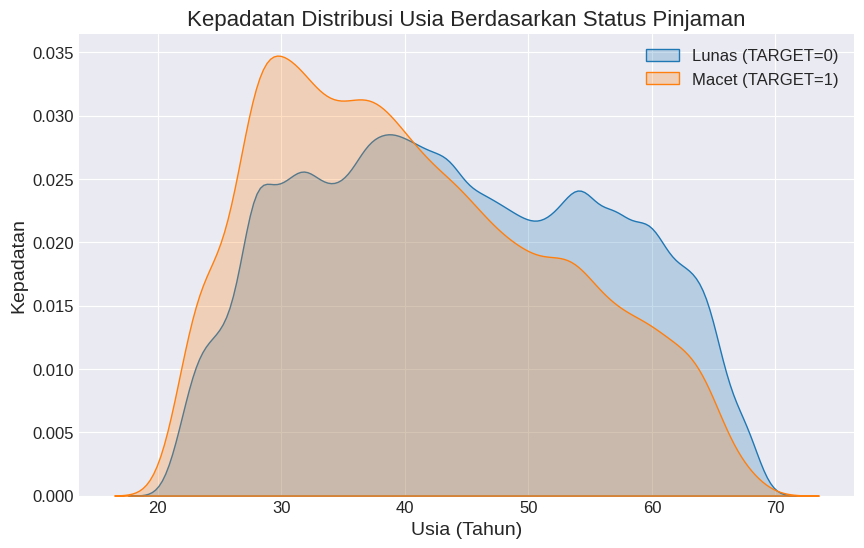

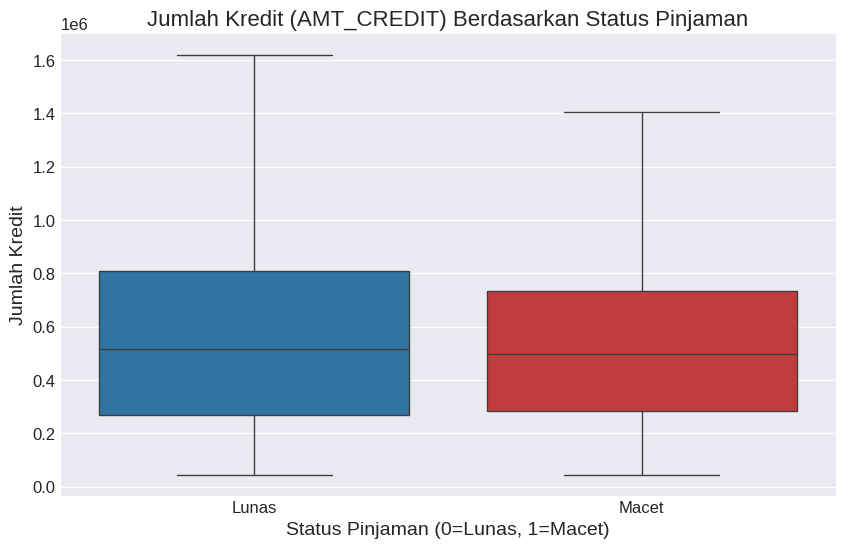

In [ ]:
# =====================================================================
# TAHAP 5: VISUALISASI INSIGHT
# =====================================================================
#----------Pengaturan Plot Top N Business Insights-------------
sns.set_style("whitegrid") # Gaya plot
plt.style.use('seaborn-v0_8-darkgrid') # Gaya tambahan dari matplotlib
plt.rcParams['figure.figsize'] = (10, 6) # Ukuran default figure
plt.rcParams['font.size'] = 12 # Ukuran font default
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

#Insight 1: Dampak Usia terhadap Risiko Kredit (Numerik)
# Pastikan 'AGE_IN_YEARS' sudah dibuat di Feature Engineering
# Jika belum, buat di sini:
df_train['AGE_IN_YEARS'] = df_train['DAYS_BIRTH'] / -365

plt.figure(figsize=(10, 6))
sns.histplot(df_train, x='AGE_IN_YEARS', hue='TARGET', multiple='stack', bins=30, kde=True, palette=['#1f77b4', '#d62728'])
plt.title('Distribusi Usia Berdasarkan Status Pinjaman')
plt.xlabel('Usia (Tahun)')
plt.ylabel('Jumlah Aplikasi')
plt.legend(title='Status', labels=['Lunas (0)', 'Macet (1)'])
plt.show()

# Atau menggunakan Kernel Density Estimate (KDE) plot untuk melihat kepadatan
plt.figure(figsize=(10, 6))
sns.kdeplot(df_train.loc[df_train['TARGET'] == 0, 'AGE_IN_YEARS'], label='Lunas (TARGET=0)', fill=True)
sns.kdeplot(df_train.loc[df_train['TARGET'] == 1, 'AGE_IN_YEARS'], label='Macet (TARGET=1)', fill=True)
plt.title('Kepadatan Distribusi Usia Berdasarkan Status Pinjaman')
plt.xlabel('Usia (Tahun)')
plt.ylabel('Kepadatan')
plt.legend()
plt.show()

#Insight 3: Hubungan Jumlah Kredit (AMT_CREDIT) dengan Risiko (Numerik)
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_train, x='TARGET', y='AMT_CREDIT', palette=['#1f77b4', '#d62728'], showfliers=False) # showfliers=False untuk outliers
plt.title('Jumlah Kredit (AMT_CREDIT) Berdasarkan Status Pinjaman')
plt.xlabel('Status Pinjaman (0=Lunas, 1=Macet)')
plt.ylabel('Jumlah Kredit')
plt.xticks([0, 1], ['Lunas', 'Macet'])
plt.show()

# Bisa juga melihat distribusi logaritmik jika datanya sangat miring
# df_train['LOG_AMT_CREDIT'] = np.log1p(df_train['AMT_CREDIT'])
# sns.kdeplot(df_train.loc[df_train['TARGET'] == 0, 'LOG_AMT_CREDIT'], label='Lunas (TARGET=0)', fill=True)
# sns.kdeplot(df_train.loc[df_train['TARGET'] == 1, 'LOG_AMT_CREDIT'], label='Macet (TARGET=1)', fill=True)

In [ ]:
# ====================================================================================================
# TAHAP 6: MODEL
# ====================================================================================================

# --- LOGISTIC REGRESSION ---
# Kita butuh 'StandardScaler' karena LogReg sensitif terhadap skala angka (juta vs tahun)
logreg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42))
])

# Training
logreg_pipeline.fit(X_train, y_train)

# Evaluasi Cepat
y_pred_lr = logreg_pipeline.predict(X_test)
y_prob_lr = logreg_pipeline.predict_proba(X_test)[:, 1]

print("ROC-AUC LogReg:", roc_auc_score(y_test, y_prob_lr))

# --- XGBOOST ---
# scale_pos_weight adalah parameter ajaib untuk data tidak seimbang.
# Rumusnya biasanya: sum(negative instances) / sum(positive instances)
ratio = float(np.sum(y == 0)) / np.sum(y == 1)

xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    scale_pos_weight=ratio, # Penting agar model "memperhatikan" kelas minoritas (Macet)
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Training
xgb_model.fit(X_train, y_train)

# Evaluasi Cepat
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

print("ROC-AUC XGBoost:", roc_auc_score(y_test, y_prob_xgb))


# --- CROSS VALIDATION STRATEGY ---
# Membagi data latih menjadi 5 bagian (folds).
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cek stabilitas XGBoost
scores = cross_val_score(xgb_model, X_train, y_train, cv=cv_strategy, scoring='roc_auc')

print(f"Rata-rata AUC 5-Fold: {scores.mean():.4f}")
print(f"Standar Deviasi: {scores.std():.4f}") # Semakin kecil std, model semakin stabil

ROC-AUC LogReg: 0.7404628750612239
ROC-AUC XGBoost: 0.7605995871129745
Rata-rata AUC 5-Fold: 0.7575
Standar Deviasi: 0.0024


=== Ringkasan Performa Model ===


,AUC,Accuracy,Precision (1),Recall (1),F1-Score (1)
Model,,,,,
Logistic Regression,0.740463,0.686097,0.157749,0.665660,0.255055
XGBoost,0.760600,0.707494,0.169265,0.671299,0.270360


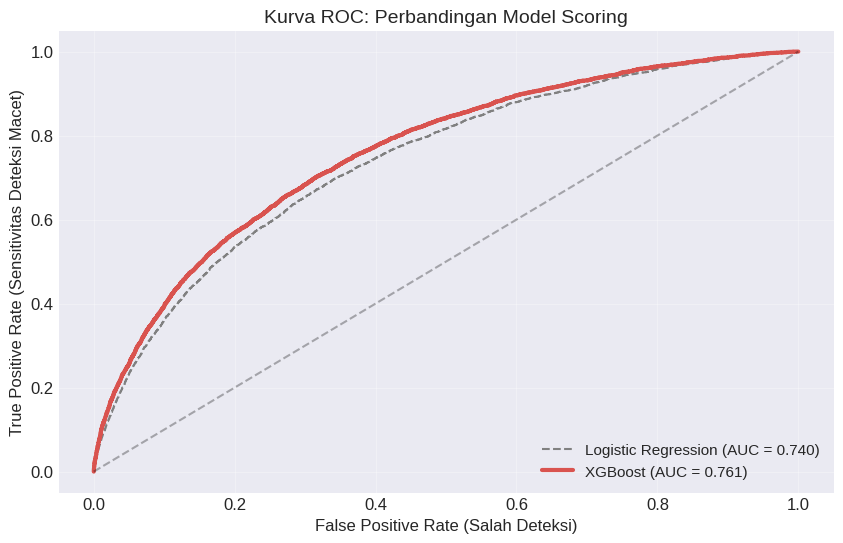

In [ ]:
# Fungsi helper untuk menghitung metrik
def get_metrics(y_true, y_pred, y_proba, model_name):
    return {
        'Model': model_name,
        'AUC': roc_auc_score(y_true, y_proba),
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision (1)': precision_score(y_true, y_pred),
        'Recall (1)': recall_score(y_true, y_pred),
        'F1-Score (1)': f1_score(y_true, y_pred)
    }

# Hitung metrik untuk LogReg
metrics_lr = get_metrics(y_test, y_pred_lr, y_prob_lr, 'Logistic Regression')

# Hitung metrik untuk XGBoost
metrics_xgb = get_metrics(y_test, y_pred_xgb, y_prob_xgb, 'XGBoost')

# Buat DataFrame perbandingan
df_comparison = pd.DataFrame([metrics_lr, metrics_xgb])
df_comparison.set_index('Model', inplace=True)

# Tampilkan Tabel
print("=== Ringkasan Performa Model ===")
display(df_comparison)

# Hitung FPR, TPR, dan Thresholds
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)

plt.figure(figsize=(10, 6))

# Plot LogReg
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {metrics_lr["AUC"]:.3f})',
         linestyle='--', color='gray')

# Plot XGBoost
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {metrics_xgb["AUC"]:.3f})',
         linewidth=3, color='#d9534f') # Merah tebal untuk Champion

# Garis diagonal (Random Guess)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.3)

plt.title('Kurva ROC: Perbandingan Model Scoring', fontsize=14)
plt.xlabel('False Positive Rate (Salah Deteksi)', fontsize=12)
plt.ylabel('True Positive Rate (Sensitivitas Deteksi Macet)', fontsize=12)
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)

# Simpan gambar
plt.savefig('roc_curve_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

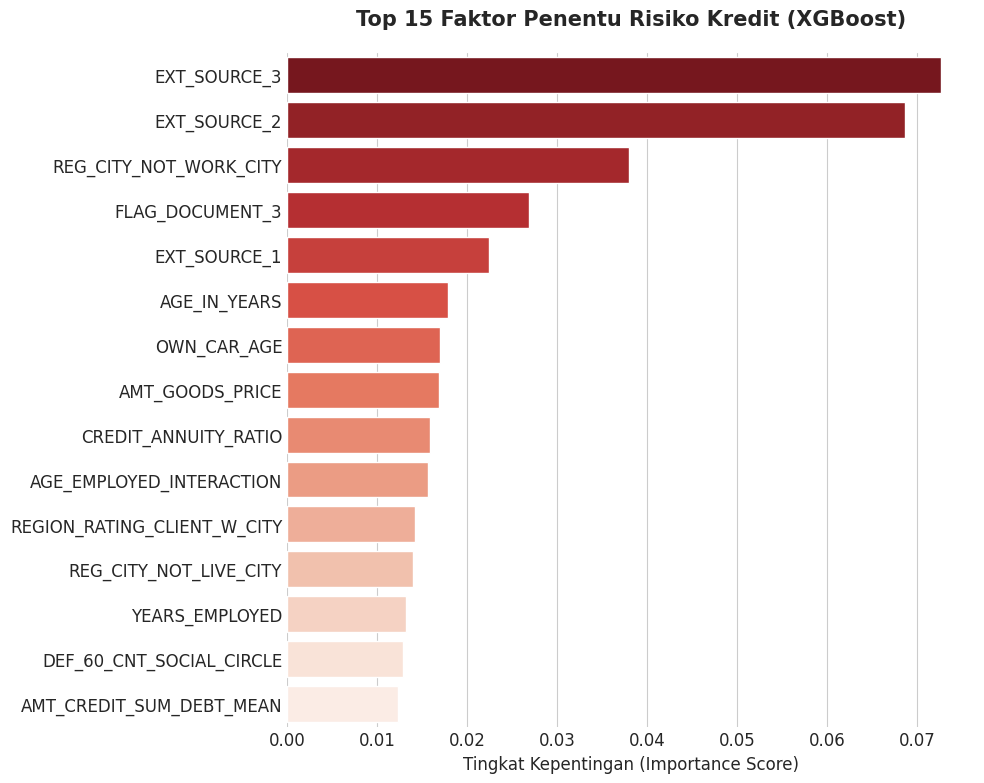

In [ ]:
# 1. Ambil Feature Importance dari Model
# Pastikan nama kolom tersedia (ambil dari X_train.columns)
feature_names = X_train.columns
importance_scores = xgb_model.feature_importances_

# 2. Buat DataFrame dan Urutkan
df_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance_scores
})

# Ambil Top 15 Fitur Teratas
df_imp = df_imp.sort_values(by='Importance', ascending=False).head(15)

# 3. Visualisasi Cantik (Seaborn)
plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")

# Barplot Horizontal
# Palette 'Reds_r' agar yang paling penting warnanya paling gelap/tegas
ax = sns.barplot(x='Importance', y='Feature', data=df_imp, palette='Reds_r')

# Kosmetik Plot
plt.title('Top 15 Faktor Penentu Risiko Kredit (XGBoost)', fontsize=15, fontweight='bold', pad=20)
plt.xlabel('Tingkat Kepentingan (Importance Score)', fontsize=12)
plt.ylabel(None)

# Simpan gambar
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300)
plt.show()